In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import salishsea_tools

import datetime
import os

import nowcast
import nowcast.figures.shared

from matplotlib import gridspec

from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools, geo_tools)

%matplotlib inline

import scipy.io as sio

In [2]:
coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')

In [3]:
def results_dataset(results_dir, date, period, grid_type):
    datestr = date.strftime('%Y%m%d')
    subdir = date.strftime('%d%b%y').lower()
    fname = os.path.join(results_dir, subdir,
                        'SalishSea_{}_{}_{}_{}.nc'.format(period, datestr, datestr, grid_type))
    grid = nc.Dataset(fname)
    return grid

In [4]:
filename = '/results/SalishSea/nowcast-green/28feb16/SalishSea_1d_20160228_20160228_ptrc_T.nc'
grid_g = nc.Dataset(filename)
thalweg = np.loadtxt('/data/nsoontie/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)

vnames=grid_g.variables.keys()
print(vnames)
excluded={'nav_lat', 'nav_lon', 'deptht', 'time_centered', 'time_centered_bounds','deptht_bounds',
          'time_counter','time_counter_bounds'}
vnames=[x for x in vnames if x not in excluded]
print(vnames)


odict_keys(['DOC', 'MICZ', 'MYRI', 'NH4', 'NO3', 'O2', 'PHY', 'PHY2', 'POC', 'Si', 'bSi', 'deptht', 'deptht_bounds', 'nav_lat', 'nav_lon', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds'])
['DOC', 'MICZ', 'MYRI', 'NH4', 'NO3', 'O2', 'PHY', 'PHY2', 'POC', 'Si', 'bSi']


In [5]:
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, model_lons, model_lats = tidetools.get_bathy_data(grid_B)

In [6]:
zlevels = grid_g.variables['deptht'][:]
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)

In [7]:
def _prep_plot_data(var):
    si, ei = 200, 610
    sj, ej = 20, 370
    lons = grid_T_hr.variables['nav_lon'][si:ei, sj:ej]
    lats = grid_T_hr.variables['nav_lat'][si:ei, sj:ej]

    sal_hr[model_time_step, model_depth_level, si:ei, sj:ej], 0)
    timestamped_sal = namedtuple('timestamped_sal', 'salinity, timestamp')
    sal_model = timestamped_sal(
        teos_tools.psu_teos(sal_masked),
        nc_tools.timestamp(grid_T_hr, model_time_step))
    return lons, lats, sal_model, None


SyntaxError: invalid syntax (<ipython-input-7-1331aa41f6ae>, line 7)

In [14]:
def tracer_thalweg_and_surface(grid_T, var_name, bathy, lons, lats, mesh_mask):
    
    var = grid_T.variables[var_name][0,:,:,:]
    
    lon_range = (-124.2,-122.6)
    lat_range = (48,49.6)
    
    
    vmin = 6
    vmax = 34
    clevels = np.arange(vmin,vmax,1)
    
    fig = plt.figure(figsize=(16, 8)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.68, 1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    cmap = plt.get_cmap('jet')
    
    
    
    cbar = vis.contour_thalweg(ax1, var, bathy, lons, lats, mesh_mask, 'gdept', clevels = clevels, cmap=cmap)
    ax1.set_ylim([450,0])
    cbar.remove()
        
    viz_tools.set_aspect(ax1)
    
    si, ei = 165, 590
    sj, ej = 55, 365
    lons = lons[si:ei, sj:ej]
    lats = lats[si:ei, sj:ej]
    var = var[0,si:ei, sj:ej]
    var_ma = np.ma.masked_values(var[:, :], 0)
    
    nowcast.figures.shared.plot_map(ax2,coastline, lon_range = lon_range, lat_range = lat_range)
    mesh = ax2.contourf(lons, lats, var_ma, levels = clevels, cmap=cmap,extend='both', vmin=vmin, vmax=vmax)
    
    
    #mesh = ax2.pcolormesh(var[0,:,:], cmap='jet')#, vmin=vmin, vmax=vmax)
    fig.colorbar(mesh, ax=ax2,fraction=0.046, pad=0.04)
    #ax2.set_title('Surface {label}'.format(label=conc.long_name.title()), fontsize=16)
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.tight_layout()
    
    return(fig)

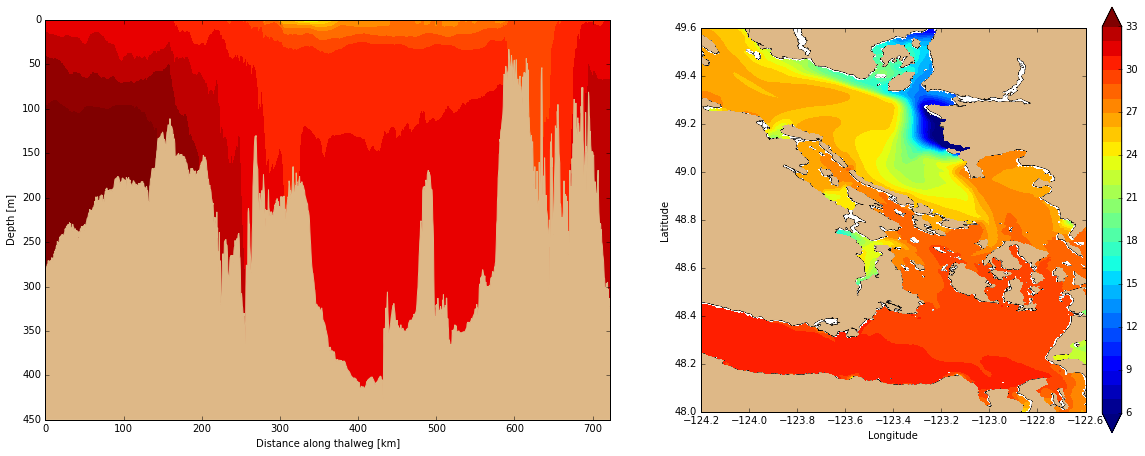

In [15]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')


grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, lons, lats = tidetools.get_bathy_data(grid_B)

nowcast_dir = '/results/SalishSea/nowcast/'
date = datetime.datetime(2016, 4, 4)
grid_T = results_dataset(nowcast_dir, date, '1d', 'grid_T')

var = grid_T.variables['vosaline'][0,:,:,:]

a = tracer_thalweg_and_surface(var, bathy, lons, lats, mesh_mask)
plt.show(a)